In [ ]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from matplotlib import collections


from set_home_directory import get_project_root_homedir_in_sys_path
project_root, main_dir = get_project_root_homedir_in_sys_path("inter_areal_predictability")
if project_root is None:
    raise RuntimeError(f"Project root not found: ensure a folder named '{project_root}' exists in one of the sys.path entries.")
print("Project root found:", project_root)
os.chdir(project_root)

fig_dir = os.path.join(project_root, 'results/paper_figures/')

import sys
sys.path.insert(0,os.path.join(main_dir,'utils/'))
sys.path.insert(0,main_dir)

from utils.beh_contrib_functions import make_mouse_df, three_plot, make_monkey_df
from utils.fig_4_functions import add_violin_custom_colors_3, add_group_pairwise_stars_2_sets
from utils.stats_functions import perm_test_paired
save_figs = False
temp_fig_dir = os.path.join(project_root, 'results/paper_figures/revisions/')

Project root found: /Users/diannahidalgo/Documents/thesis_shenanigans/aim2_project


### Import stats

In [32]:
mouse_stats_path = os.path.join(project_root, 'results/fig_2',f'mouse_stats.pkl')
with open(mouse_stats_path, 'rb') as f:
	mouse_stats = pickle.load(f)


monkey_name='L'
monkey=monkey_name
monkey_stats_path = os.path.join(project_root, 'results/fig_2',f'monkey_{monkey_name}_stats.pkl')
with open(monkey_stats_path, 'rb') as f:
	monkey_stats = pickle.load(f)
 
palette = {
    "EV": "#2F2F2F",             # dark
    "EV (behavior)": "#D9D9D9",  # light
    "EV (combined)": "#7A7A7A",  # mid
    "shuffle": "#EEEEEE",
    "control IQR": "#BDBDBD",
}

### Mouse

In [33]:
mouse_df = make_mouse_df(mouse_stats, dataset_types=['stimspont'])
mouse_df_melted = mouse_df.melt(id_vars=['Dataset Type', 'Activity Type', 'Mouse', 'Mouse Name', 'Area', 'SNR', 'Split-half r', 'control_shuffle', 'Cell Number','Direction'], 
								value_vars=['EV', 'EV (behavior)', 'EV (combined)'], 
								var_name='EV Type', value_name='EV Value')

In [ ]:
# Fig Supp 10A
filt_mouse_df_melted = mouse_df_melted[(mouse_df_melted.control_shuffle==False)].reset_index(drop=True)
filt_mouse_df_melted_null= mouse_df_melted[(mouse_df_melted.control_shuffle==True)].reset_index(drop=True)
neuron_property = 'EV Value'
variable1 = 'Direction'
variable2='EV Type'
directions= ['L4→L2/3', 'L2/3→L4']
fig, ax = plt.subplots(figsize=(3.5,1.5))
fontsize=6
three_plot(filt_mouse_df_melted, x='Direction', y='EV Value', hue='EV Type', 
			ax=ax, label_order=directions, hue_order=['EV', 'EV (behavior)', 'EV (combined)'],linewidth=0.3,palette=palette,cut=0)
ax.legend_.remove()
sns.despine()
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
sns.despine()
ax.spines[:].set_linewidth(0.3)
add_violin_custom_colors_3(ax, custom_colors=['#136a66','#B6E3DF','#72BEB7','#a85959','#f6d6d6','#EDAEAE'])
add_group_pairwise_stars_2_sets(filt_mouse_df_melted, neuron_property, x=variable1, x_order=directions,
                       hue=variable2, hue_order=['EV', 'EV (behavior)', 'EV (combined)'], ax=ax, fontsize=fontsize,height1=0.85, height2=0.95, height3=0.85,
                       stars1_positions=[0.16,0.23,0.30],
                       stars2_positions=[0.69,0.77,0.83], hierarchical=True)
data = mouse_df[(mouse_df['control_shuffle']==True)&(mouse_df['Split-half r']>0.8)&(mouse_df.SNR>=2)]['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )

# get the legend colors from the violin plot
handles, labels = ax.get_legend_handles_labels()
for handle in handles:
	if isinstance(handle, collections.PolyCollection):
		handle.set_edgecolor('black')
		handle.set_linewidth(0.2)
ax.legend(fontsize=fontsize*0.8, frameon=False, handlelength=1, handletextpad=0.2, loc=(0.95,0.7))

if save_figs:
	if not os.path.exists(temp_fig_dir):
		os.makedirs(temp_fig_dir)
	fig.savefig(os.path.join(temp_fig_dir, f'R2.4_mouse_behavior_predictability_spont.pdf'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [34]:
stats_null_df = mouse_df[(mouse_df['control_shuffle']==True)&(mouse_df['Split-half r']>0.8)&(mouse_df.SNR>=2)].reset_index(drop=True)
stats_df = mouse_df[(mouse_df['control_shuffle']==False)&(mouse_df['Split-half r']>0.8)&(mouse_df.SNR>=2)].reset_index(drop=True)
merged_stats_df = stats_df.merge(stats_null_df, on=['Dataset Type', 'Activity Type', 'Mouse', 'Mouse Name', 'Area', 'Cell Number','Direction'], suffixes=('', '_null'))
ev_behavior = merged_stats_df['EV (behavior)']
ev_behavior_null = merged_stats_df['EV (behavior)_null']


p_value_beh = perm_test_paired(ev_behavior.values, ev_behavior_null.values)
print(p_value_beh)


0.0


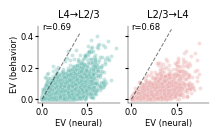

In [42]:
# Fig Supp 10B
# plot correlations between EV and EV(behavior) for L23 and L4
colors = {'L2/3': '#73BFB7',
		  'L4': '#EDAEAE'}
colors = {'L4→L2/3': '#73BFB7',
		  'L2/3→L4': '#EDAEAE'}
fontsize=6
fig, axes = plt.subplots(1,2, figsize=(2.2,1), sharey=True, sharex=True)
for ax, dir in zip(axes.flatten(), mouse_df['Direction'].unique()):
	sns.scatterplot(x='EV', data=mouse_df[(mouse_df['Direction']==dir)&(mouse_df['control_shuffle']==False)], y='EV (behavior)', ax=ax,
					color=colors[dir], s=fontsize*1.3, alpha=0.4)
	ax.tick_params(axis='both', labelsize=fontsize, length=2.5, pad=1)
	ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize, labelpad=1)
	ax.set_xlabel('EV (neural)', fontsize=fontsize, labelpad=1)
	ax.set_title(dir, fontsize=fontsize*1.2)
	ax.spines[:].set_linewidth(0.3)
	sns.despine()
	# plot corr value on top
	corr = mouse_df[(mouse_df['Direction']==dir)&(mouse_df['control_shuffle']==False)]['EV'].corr(mouse_df[(mouse_df['Direction']==dir)&(mouse_df['control_shuffle']==False)]['EV (behavior)'])
	ax.text(0.05, 0.95, f'r={corr:.2f}', transform=ax.transAxes, fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)
for ax in axes.flatten():
	xmin, xmax = ax.get_xlim()
	ymin, ymax = ax.get_ylim()
	low  = 0
	high = min(xmax, ymax)

	ax.plot([low, high], [low, high], linestyle='--', linewidth=0.75, color='k', alpha=0.5)

if save_figs:
	if not os.path.exists(temp_fig_dir):
		os.makedirs(temp_fig_dir)
	fig.savefig(os.path.join(temp_fig_dir, f'R2.4_mouse_scatter_EV_vs_EV_behavior_spont.pdf'), dpi=300, bbox_inches='tight', transparent=True)

#### spont

In [37]:
mouse_df = make_mouse_df(mouse_stats, dataset_types=['stimspont_spont'])

mouse_df_melted = mouse_df.melt(id_vars=['Dataset Type', 'Activity Type', 'Mouse', 'Mouse Name', 'Area', 'SNR', 'Split-half r', 'control_shuffle', 'Cell Number','Direction'], 
								value_vars=['EV', 'EV (behavior)', 'EV (combined)'], 
								var_name='EV Type', value_name='EV Value')

filt_mouse_df_melted =mouse_df_melted[(mouse_df_melted.control_shuffle==False)&(mouse_df_melted['Split-half r']>0.8)&(mouse_df_melted.SNR>=2)].reset_index(drop=True)
filt_mouse_df_melted_null= mouse_df_melted[(mouse_df_melted.control_shuffle==True)&(mouse_df_melted['Split-half r']>0.8)&(mouse_df_melted.SNR>=2)].reset_index(drop=True)

comparing EV vs EV (behavior), n=3488 vs n=3488


KeyboardInterrupt: 

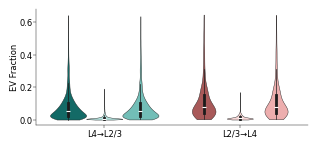

In [36]:
# Fig Supp 10C

neuron_property = 'EV Value'
variable1 = 'Direction'
variable2='EV Type'
directions= ['L4→L2/3', 'L2/3→L4']
fig, ax = plt.subplots(figsize=(3.5,1.5))
fontsize=6
three_plot(filt_mouse_df_melted, x='Direction', y='EV Value', hue='EV Type', 
			ax=ax, label_order=directions, hue_order=['EV', 'EV (behavior)', 'EV (combined)'],
   			linewidth=0.3,palette=palette, cut=0)
ax.legend_.remove()
sns.despine()
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
sns.despine()
ax.spines[:].set_linewidth(0.3)
add_violin_custom_colors_3(ax, custom_colors=['#136a66','#B6E3DF','#72BEB7','#a85959','#f6d6d6','#EDAEAE'])
add_group_pairwise_stars_2_sets(filt_mouse_df_melted, neuron_property, x=variable1, x_order=directions,
                       hue=variable2, hue_order=['EV', 'EV (behavior)', 'EV (combined)'], ax=ax, fontsize=fontsize,height1=0.85, height2=0.95, height3=0.85,
                       stars1_positions=[0.16,0.23,0.30],
                       stars2_positions=[0.69,0.77,0.83], hierarchical=True)
data = mouse_df[(mouse_df['control_shuffle']==True)&(mouse_df['Split-half r']>0.8)&(mouse_df.SNR>=2)]['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )

# get the legend colors from the violin plot
handles, labels = ax.get_legend_handles_labels()
for handle in handles:
	if isinstance(handle, collections.PolyCollection):
		handle.set_edgecolor('black')
		handle.set_linewidth(0.2)
ax.legend(fontsize=fontsize*.8, frameon=False, handlelength=1, handletextpad=0.2, loc=(0.95,0.7))
ax.legend_.remove()
ax.set_title('Spontaneous Activity', fontsize=fontsize*1.2, pad=3)
if save_figs:
	if not os.path.exists(temp_fig_dir):
		os.makedirs(temp_fig_dir)
	fig.savefig(os.path.join(temp_fig_dir, f'R.2.4_mouse_behavior_predictability_spont_spont.pdf'), dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [38]:
stats_null_df = mouse_df[(mouse_df['control_shuffle']==True)&(mouse_df['Split-half r']>0.8)&(mouse_df.SNR>=2)].reset_index(drop=True)
stats_df = mouse_df[(mouse_df['control_shuffle']==False)&(mouse_df['Split-half r']>0.8)&(mouse_df.SNR>=2)].reset_index(drop=True)
merged_stats_df = stats_df.merge(stats_null_df, on=['Dataset Type', 'Activity Type', 'Mouse', 'Mouse Name', 'Area', 'Cell Number','Direction'], suffixes=('', '_null'))
ev_behavior = merged_stats_df['EV (behavior)']
ev_behavior_null = merged_stats_df['EV (behavior)_null']

from utils.stats_functions import perm_test_paired
p_value_beh = perm_test_paired(ev_behavior.values, ev_behavior_null.values)
print(p_value_beh)

0.0


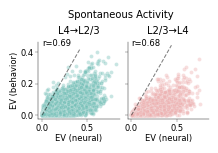

In [41]:
# plot correlations between EV and EV(behavior) for L23 and L4
colors = {'L4→L2/3': '#73BFB7',
		  'L2/3→L4': '#EDAEAE'}
fontsize=6
fig, axes = plt.subplots(1,2, figsize=(2.2,1), sharey=True, sharex=True)
for ax, dir in zip(axes.flatten(), mouse_df['Direction'].unique()):
	sns.scatterplot(x='EV', data=mouse_df[(mouse_df['Direction']==dir)&(mouse_df['control_shuffle']==False)], y='EV (behavior)', ax=ax,
					color=colors[dir], s=fontsize*1.3, alpha=0.4)
	ax.tick_params(axis='both', labelsize=fontsize, width=0.2, length=2.5, pad=1)
	ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize, labelpad=1)
	ax.set_xlabel('EV (neural)', fontsize=fontsize, labelpad=1)
	ax.set_title(dir, fontsize=fontsize*1.2)
	ax.spines[:].set_linewidth(0.3)
	sns.despine()
	# plot corr value on top
	corr = mouse_df[(mouse_df['Direction']==dir)&(mouse_df['control_shuffle']==False)]['EV'].corr(mouse_df[(mouse_df['Direction']==dir)&(mouse_df['control_shuffle']==False)]['EV (behavior)'])
	ax.text(0.05, 0.95, f'r={corr:.2f}', transform=ax.transAxes, fontsize=fontsize)
plt.subplots_adjust(wspace=0.1)

for ax in axes.flatten():
	xmin, xmax = ax.get_xlim()
	ymin, ymax = ax.get_ylim()
	low  = 0
	high = min(xmax, ymax)

	ax.plot([low, high], [low, high], linestyle='--', linewidth=0.75, color='k', alpha=0.5)

fig.suptitle('Spontaneous Activity', fontsize=fontsize*1.2, y=1.2)
if save_figs:
	if not os.path.exists(temp_fig_dir):
		os.makedirs(temp_fig_dir)
	fig.savefig(os.path.join(temp_fig_dir, f'R2.4_scatter_EV_vs_EV_behavior_spont_spont.pdf'), dpi=300, bbox_inches='tight',transparent=True)
plt.show()

### macaque L

In [11]:
monkey_df = make_monkey_df(monkey_stats, dataset_types=['RS_open'])
monkey_df_melted = monkey_df.melt(id_vars=['Dataset Type', 'Activity Type', 'Date', 'Area', 'SNR', 'Split-half r', 'control_shuffle', 'Cell Number','Direction'], 
								value_vars=['EV', 'EV (behavior)', 'EV (combined)'], 
								var_name='EV Type', value_name='EV Value')

090817
100817


comparing EV vs EV (behavior), n=156 vs n=156
comparing EV vs EV (combined), n=156 vs n=156
comparing EV (behavior) vs EV (combined), n=156 vs n=156
EV_EV (behavior) 0.0
EV_EV (combined) 1.0
EV (behavior)_EV (combined) 0.0
comparing EV vs EV (behavior), n=1142 vs n=1142
comparing EV vs EV (combined), n=1142 vs n=1142
comparing EV (behavior) vs EV (combined), n=1142 vs n=1142
EV_EV (behavior) 0.0
EV_EV (combined) 0.6959
EV (behavior)_EV (combined) 0.0


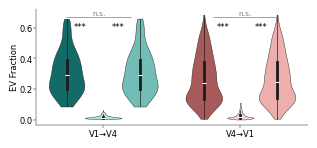

In [4]:
# Fig Supp 10E

filt_monkey_df_melted =monkey_df_melted[(monkey_df_melted.control_shuffle==False)&(monkey_df_melted['Split-half r']>0.8)&(monkey_df_melted.SNR>=2)].reset_index(drop=True)
filt_monkey_df_melted_null= monkey_df_melted[(monkey_df_melted.control_shuffle==True)&(monkey_df_melted['Split-half r']>0.8)&(monkey_df_melted.SNR>=2)].reset_index(drop=True)
neuron_property = 'EV Value'
variable1 = 'Direction'
variable2='EV Type'
directions= filt_monkey_df_melted['Direction'].unique()

fig, ax = plt.subplots(figsize=(3.5,1.5))
fontsize=6
three_plot(filt_monkey_df_melted, x='Direction', y='EV Value', hue='EV Type', 
			ax=ax, label_order=directions, hue_order=['EV', 'EV (behavior)', 'EV (combined)'],
   			linewidth=0.3,palette=palette, cut=0)
ax.legend_.remove()
sns.despine()
ax.set_ylabel('EV Fraction', fontsize=fontsize, labelpad=0)
ax.tick_params(axis='both', labelsize=fontsize, width=0.3, length=2, pad=1)
sns.despine()
ax.spines[:].set_linewidth(0.3)
add_violin_custom_colors_3(ax, custom_colors=['#136a66','#B6E3DF','#72BEB7','#a85959','#f6d6d6','#EDAEAE'])
add_group_pairwise_stars_2_sets(filt_monkey_df_melted, neuron_property, x=variable1, x_order=directions,
                       hue=variable2, hue_order=['EV', 'EV (behavior)', 'EV (combined)'], ax=ax, fontsize=fontsize,height1=0.85, height2=0.95, height3=0.85,
                       stars1_positions=[0.16,0.23,0.30],
                       stars2_positions=[0.69,0.77,0.83])
data = monkey_df[(monkey_df['control_shuffle']==True)&(monkey_df['Split-half r']>0.8)&(monkey_df.SNR>=2)]['EV']
per_25 = np.percentile(data.dropna().values, 25)
per_75 = np.percentile(data.dropna().values, 75)
ax.axhspan(per_25, per_75, alpha=0.1, color='blue', label='shuffle\ncontrol IQR',
        linewidth=0,
           )

# get the legend colors from the violin plot
handles, labels = ax.get_legend_handles_labels()
for handle in handles:
	if isinstance(handle, collections.PolyCollection):
		handle.set_edgecolor('black')
		handle.set_linewidth(0.2)
ax.legend(fontsize=fontsize*0.8, frameon=False, handlelength=1, handletextpad=0.2, loc=(0.95,0.7))
ax.legend_.remove()
if save_figs is True:
	if not os.path.exists(temp_fig_dir):
		os.makedirs(temp_fig_dir)
	fig.savefig(os.path.join(temp_fig_dir, f'R2.4_behavior_monkey_V4_V1_direction_comparison_.pdf'),  dpi=300, bbox_inches='tight', transparent=True)
plt.show()

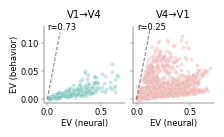

In [43]:
# Fig Supp 10F

# plot correlations between EV and EV(behavior) for L23 and L4
colors = {'V4': '#73BFB7',
		  'V1': '#EDAEAE'}
colors = {'V1→V4': '#73BFB7',
		  'V4→V1': '#EDAEAE'}
fontsize=6
fig, axes = plt.subplots(1,2, figsize=(2.2,1), sharey=True, sharex=True)
for ax, dir in zip(axes.flatten(), monkey_df['Direction'].unique()):
	sns.scatterplot(x='EV', data=monkey_df[(monkey_df['Direction']==dir)&(monkey_df['control_shuffle']==False)], y='EV (behavior)', ax=ax,
					color=colors[dir], s=fontsize*1.3, alpha=0.4)
	ax.tick_params(axis='both', labelsize=fontsize, width=0.2, length=2.5, pad=1)
	ax.set_ylabel(ax.get_ylabel(), fontsize=fontsize, labelpad=1)
	ax.set_xlabel('EV (neural)', fontsize=fontsize, labelpad=1)
	ax.set_title(dir, fontsize=fontsize*1.2)
	ax.spines[:].set_linewidth(0.3)
	sns.despine()
	# plot corr value on top
	corr = monkey_df[(monkey_df['Direction']==dir)&(monkey_df['control_shuffle']==False)]['EV'].corr(monkey_df[(monkey_df['Direction']==dir)&(monkey_df['control_shuffle']==False)]['EV (behavior)'])
	ax.text(0.05, 0.95, f'r={corr:.2f}', transform=ax.transAxes, fontsize=fontsize)

for ax in axes.flatten():
	xmin, xmax = ax.get_xlim()
	ymin, ymax = ax.get_ylim()
	low  = 0
	high = min(xmax, ymax)

	ax.plot([low, high], [low, high], linestyle='--', linewidth=0.75, color='k', alpha=0.5)

plt.subplots_adjust(wspace=0.1)
if save_figs is True:
	fig.savefig(os.path.join(temp_fig_dir, f'R2.4_behavior_monkey_EV_correlation_V4_V1.pdf'),  dpi=300, bbox_inches='tight', transparent=True)